# Vessel Type Classification

The goal of this project is to classify vessel types using AIS data and to become familiar with PySpark and Plotly packages.

The data was acquired from [MarinceCadastre.gov](https://marinecadastre.gov/ais/).

The GitHub repository for this project can be found  [here](https://github.com/nicksento/Vessel-Type-Classification).

# Import Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.types import *

import pandas as pd

In [2]:
spark = SparkSession \
    .builder \
    .appName("Maritime") \
    .getOrCreate()

In [3]:
# load data
static_df = spark.read.options(header=True, inferSchema=True, col=['sourcemmsi', 'imonumber']).csv('Data/nari_static.csv')

In [4]:
static_df.limit(5).toPandas().head()

,sourcemmsi,imonumber,callsign,shipname,shiptype,tobow,tostern,tostarboard,toport,eta,draught,destination,mothershipmmsi,t
0,304091000,9509255,V2GU5,HC JETTE-MARIT,70,130,30,18,6,04-09 20:00,10.1,BREST,NaN,1443650423
1,228037600,0,FIHX,AEROUANT BREIZH,30,6,9,5,2,00-00 24:60,0.0,,NaN,1443650457
2,228064900,8304816,FITO,VN SAPEUR,51,21,54,10,6,29-09 12:00,5.9,RADE DE BREST,NaN,1443650471
3,227705102,262144,FGD5860,BINDY,60,9,26,5,4,00-00 24:60,0.0,,NaN,1443650474
4,227415000,0,FHAF,F/V JEREMI SIMON,90,11,9,3,3,00-00 24:60,0.0,,NaN,1443650479


In [5]:
# dataframe shape
print((static_df.count(), len(static_df.columns)))

(1078617, 14)


We are going to keep only one record of each ship.

In [6]:
# drop duplicates
dropDF = static_df.dropDuplicates(["sourcemmsi"])

In [7]:
static_df1 = dropDF.select(['sourcemmsi', 'shiptype', 'tobow',
                     'tostern', 'tostarboard', 'draught'])

In [8]:
static_df1.toPandas().isna().sum()

sourcemmsi       0
shiptype       212
tobow          212
tostern        212
tostarboard    212
draught        401
dtype: int64

In [9]:
static_df1 = static_df1.filter(dropDF.shiptype. isNotNull())

In [10]:
static_df1.toPandas().isna().sum()

sourcemmsi       0
shiptype         0
tobow            0
tostern          0
tostarboard      0
draught        189
dtype: int64

Add an empty column

In [11]:
static_df1 = static_df1.withColumn("type_summary", lit(None).cast(StringType()))

In [12]:
static_df1.limit(5).toPandas().head()

,sourcemmsi,shiptype,tobow,tostern,tostarboard,draught,type_summary
0,357851000,80,120,26,7,9.8,None
1,227312180,30,7,8,3,2.0,None
2,250001396,70,80,10,7,5.7,None
3,305737000,79,124,14,8,6.2,None
4,205554000,79,258,34,17,8.6,None


In [13]:
ship_types_df = pd.read_csv("Data/Ship Types List.csv")

In [14]:
ship_types_df.head(100)

,id_shiptype,shiptype_min,shiptype_max,type_name,ais_type_summary
0,1,10,19,Reserved,Unspecified
1,2,20,28,Wing In Grnd,Wing in Grnd
2,3,29,29,SAR Aircraft,Search and Rescue
3,4,30,30,Fishing,Fishing
4,5,31,31,Tug,Tug
5,6,32,32,Tug,Tug
6,7,33,33,Dredger,Special Craft
7,8,34,34,Dive Vessel,Special Craft
8,9,35,35,Military Ops,Special Craft
9,10,36,36,Sailing Vessel,Sailing Vessel


We are interested in the ais_type_summary.

In [15]:
ship_types_df.ais_type_summary.unique()

array(['Unspecified', 'Wing in Grnd', 'Search and Rescue', 'Fishing',
       'Tug', 'Special Craft', 'Sailing Vessel', 'Pleasure Craft',
       'High-Speed Craft', 'Passenger', 'Cargo', 'Tanker', 'Other'],
      dtype=object)

In [16]:
ship_types_df.ais_type_summary.nunique()

13

There are 13 distinct types of ships. 

In [17]:
#static_pandas_df = static_df1.select('shiptype', 'type_summary').toPandas()
static_pandas_df = static_df1.toPandas()

In [18]:
for i,j in enumerate(static_pandas_df.shiptype):
    for k,(l,m) in enumerate(zip(ship_types_df.shiptype_min, ship_types_df.shiptype_max)):        
        if ((l<=j<=m)):
            static_pandas_df.loc[i,'type_summary']=ship_types_df.ais_type_summary[k]
            break
            

In [19]:
static_pandas_df.head()

,sourcemmsi,shiptype,tobow,tostern,tostarboard,draught,type_summary
0,357851000,80,120,26,7,9.8,Tanker
1,227312180,30,7,8,3,2.0,Fishing
2,250001396,70,80,10,7,5.7,Cargo
3,305737000,79,124,14,8,6.2,Cargo
4,205554000,79,258,34,17,8.6,Cargo


In [20]:
test = static_pandas_df.copy()

In [21]:
test.shape

(4630, 7)

In [22]:
test.isna().sum()

sourcemmsi        0
shiptype          0
tobow             0
tostern           0
tostarboard       0
draught         189
type_summary     64
dtype: int64

In [23]:
test.dropna(subset=['type_summary'], inplace=True)
test.reset_index(drop=True, inplace=True)

In [24]:
test.shape

(4566, 7)

In [25]:
test.tail()

,sourcemmsi,shiptype,tobow,tostern,tostarboard,draught,type_summary
4561,245223000,70,76,13,5,5.3,Cargo
4562,431132000,82,141,34,18,8.0,Tanker
4563,233921000,70,18,82,5,5.4,Cargo
4564,370558000,80,144,26,19,9.4,Tanker
4565,227382750,37,8,8,2,NaN,Pleasure Craft


In [26]:
test[test['shiptype']==0].head()

,sourcemmsi,shiptype,tobow,tostern,tostarboard,draught,type_summary


In [27]:
test.isna().sum()

sourcemmsi        0
shiptype          0
tobow             0
tostern           0
tostarboard       0
draught         189
type_summary      0
dtype: int64

In [28]:
test.type_summary.unique()

array(['Tanker', 'Fishing', 'Cargo', 'Other', 'Passenger',
       'Sailing Vessel', 'Pleasure Craft', 'Special Craft',
       'Search and Rescue', 'Tug', 'High-Speed Craft', 'Wing in Grnd'],
      dtype=object)

In [29]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
le = LabelEncoder()
le.fit(test.type_summary)

LabelEncoder()

In [30]:
le.classes_

array(['Cargo', 'Fishing', 'High-Speed Craft', 'Other', 'Passenger',
       'Pleasure Craft', 'Sailing Vessel', 'Search and Rescue',
       'Special Craft', 'Tanker', 'Tug', 'Wing in Grnd'], dtype=object)

In [31]:
le.transform(test.type_summary)

array([9, 1, 0, ..., 0, 9, 5])

In [32]:
pd.Series(le.transform(test.type_summary))

0       9
1       1
2       0
3       0
4       0
       ..
4561    0
4562    9
4563    0
4564    9
4565    5
Length: 4566, dtype: int64

In [33]:
test['type_enc'] = pd.Series(le.transform(test.type_summary))

In [34]:
test[test.type_enc.isna()].head()

,sourcemmsi,shiptype,tobow,tostern,tostarboard,draught,type_summary,type_enc


In [35]:
test.shape

(4566, 8)

In [36]:
test.tail()

,sourcemmsi,shiptype,tobow,tostern,tostarboard,draught,type_summary,type_enc
4561,245223000,70,76,13,5,5.3,Cargo,0
4562,431132000,82,141,34,18,8.0,Tanker,9
4563,233921000,70,18,82,5,5.4,Cargo,0
4564,370558000,80,144,26,19,9.4,Tanker,9
4565,227382750,37,8,8,2,NaN,Pleasure Craft,5


In [37]:
test.type_enc.unique()

array([ 9,  1,  0,  3,  4,  6,  5,  8,  7, 10,  2, 11])

In [38]:
import sweetviz as sv

In [39]:
analyze_report = sv.analyze(test, target_feat='type_enc')
analyze_report.show_html('analyze.html', open_browser=False)


Report analyze.html was generated!


In [40]:
import matplotlib.pyplot as plt

In [41]:
test.groupby('type_summary').mean().head()

,sourcemmsi,shiptype,tobow,tostern,tostarboard,draught,type_enc
type_summary,,,,,,,
Cargo,3.583807e+08,71.379035,126.069278,54.908234,13.270221,8.456438,0
Fishing,2.276960e+08,30.000000,11.377644,10.652568,3.157100,2.170569,1
High-Speed Craft,2.695483e+08,40.000000,27.500000,27.500000,6.000000,3.000000,2
Other,3.055922e+08,91.927273,45.890909,43.845455,9.590909,4.714019,3
Passenger,2.635431e+08,62.950820,30.213115,142.344262,12.524590,5.583607,4


In [42]:
test2 = test[['tobow', 'tostern', 'tostarboard', 'draught', 'type_summary']]

<AxesSubplot:xlabel='type_summary'>

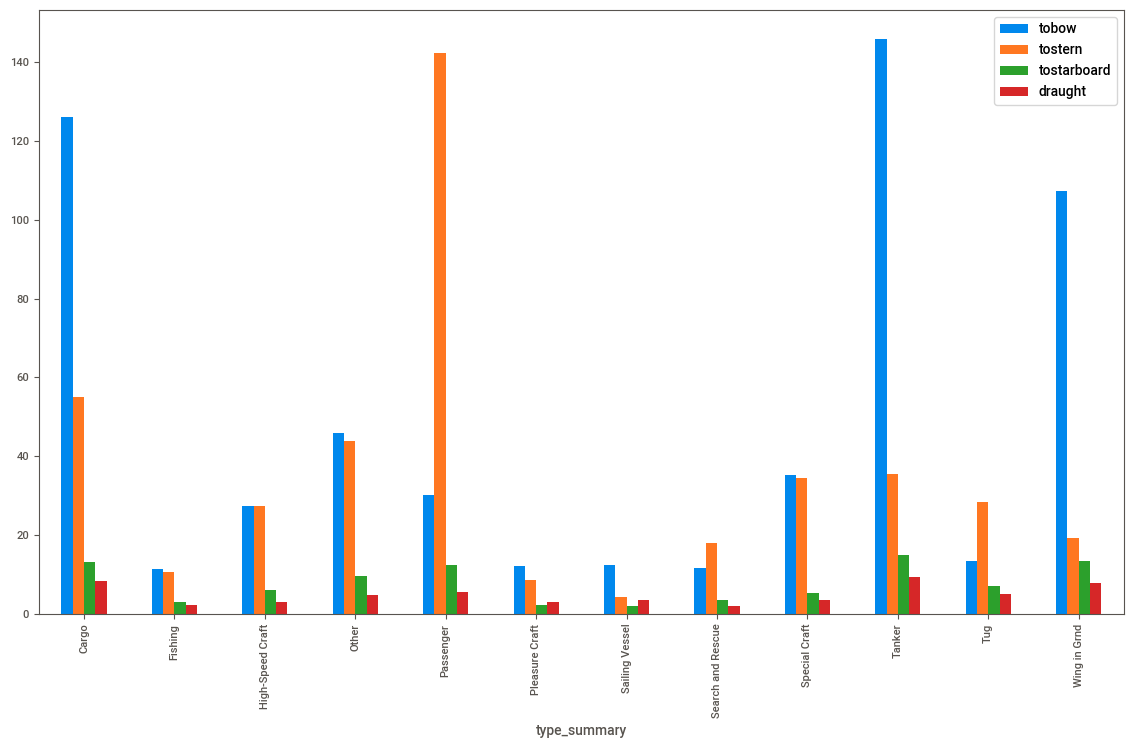

In [43]:
test2.groupby('type_summary').mean().plot( kind='bar', figsize=(14,8))

In [44]:
test_spark = spark.createDataFrame(test)

In [45]:
test_spark.show(3)

+----------+--------+-----+-------+-----------+-------+------------+--------+
|sourcemmsi|shiptype|tobow|tostern|tostarboard|draught|type_summary|type_enc|
+----------+--------+-----+-------+-----------+-------+------------+--------+
| 357851000|      80|  120|     26|          7|    9.8|      Tanker|       9|
| 227312180|      30|    7|      8|          3|    2.0|     Fishing|       1|
| 250001396|      70|   80|     10|          7|    5.7|       Cargo|       0|
+----------+--------+-----+-------+-----------+-------+------------+--------+
only showing top 3 rows



In [46]:
dynamic_df = spark.read.options(header=True, inferSchema=True).csv('Data/nari_dynamic.csv')

In [47]:
dynamic_df.limit(3).toPandas().head()

,sourcemmsi,navigationalstatus,rateofturn,speedoverground,courseoverground,trueheading,lon,lat,t
0,245257000,0,0,0.1,13.1,36,-4.465718,48.382490,1443650402
1,227705102,15,-127,0.0,262.7,511,-4.496571,48.382420,1443650403
2,228131600,15,-127,8.5,263.7,511,-4.644325,48.092247,1443650404


In [48]:
DF = dynamic_df.select('sourcemmsi','speedoverground')

In [49]:
DF = DF.groupby('sourcemmsi').avg('speedoverground')

In [50]:
#DF.show(3)

In [51]:
left_join = test_spark.join(DF, on='sourcemmsi')

In [52]:
left_join.limit(3).toPandas().head()

,sourcemmsi,shiptype,tobow,tostern,tostarboard,draught,type_summary,type_enc,avg(speedoverground)
0,227315190,30,5,9,3,NaN,Fishing,1,6.963392
1,227416000,30,12,7,1,0.0,Fishing,1,2.832258
2,228186700,51,10,60,10,6.4,Search and Rescue,7,78.763053


In [53]:
# dataframe shape
print(left_join.count())

3518


In [54]:
df = left_join.toPandas()

In [55]:
import pandas as pd
import numpy as np
import chart_studio.plotly as py
import cufflinks as cf
import seaborn as sns
import plotly.express as px
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [56]:
df.head()

,sourcemmsi,shiptype,tobow,tostern,tostarboard,draught,type_summary,type_enc,avg(speedoverground)
0,227315190,30,5,9,3,NaN,Fishing,1,6.963392
1,227416000,30,12,7,1,0.0,Fishing,1,2.832258
2,228186700,51,10,60,10,6.4,Search and Rescue,7,78.763053
3,228281000,90,0,0,0,0.0,Other,3,2.561830
4,228321000,30,12,12,4,0.0,Fishing,1,3.928750


In [57]:
meandf = df.groupby(['type_summary'],as_index=False).mean()

In [58]:
meandf.sort_values('avg(speedoverground)')

,type_summary,sourcemmsi,shiptype,tobow,tostern,tostarboard,draught,type_enc,avg(speedoverground)
6,Sailing Vessel,2.358987e+08,36.000000,12.318519,4.385185,2.037037,3.547059,6.0,4.923606
10,Tug,2.834693e+08,48.333333,13.288889,28.177778,7.066667,5.095349,10.0,4.955462
1,Fishing,2.277287e+08,30.000000,11.481132,10.660377,3.150943,2.089510,1.0,5.492856
2,High-Speed Craft,2.695483e+08,40.000000,27.500000,27.500000,6.000000,3.000000,2.0,5.565016
11,Wing in Grnd,3.834447e+08,20.000000,81.000000,14.000000,8.500000,5.600000,11.0,5.991667
5,Pleasure Craft,2.594155e+08,37.000000,11.593750,7.968750,2.187500,3.100000,5.0,6.218401
8,Special Craft,2.635526e+08,37.230769,38.564103,35.461538,5.282051,3.681818,8.0,6.900960
3,Other,2.996581e+08,91.855670,45.659794,39.546392,8.649485,4.354255,3.0,7.974578
9,Tanker,3.556611e+08,82.747887,138.163380,35.329577,14.125352,8.820563,9.0,11.184518
0,Cargo,3.495033e+08,71.407856,122.012124,53.412221,12.979146,8.195975,0.0,11.511816


In [59]:
px.bar(meandf.sort_values('avg(speedoverground)'), x='type_summary', y='avg(speedoverground)', color='type_summary')

In [60]:
px.bar(meandf.sort_values('tobow'), x='type_summary', y='tobow', color='type_summary')

In [61]:
px.bar(meandf.sort_values('tostern'), x='type_summary', y='tostern', color='type_summary')

In [62]:
px.bar(meandf.sort_values('tostarboard'), x='type_summary', y='tostarboard', color='type_summary')

In [63]:
df.head()

,sourcemmsi,shiptype,tobow,tostern,tostarboard,draught,type_summary,type_enc,avg(speedoverground)
0,227315190,30,5,9,3,NaN,Fishing,1,6.963392
1,227416000,30,12,7,1,0.0,Fishing,1,2.832258
2,228186700,51,10,60,10,6.4,Search and Rescue,7,78.763053
3,228281000,90,0,0,0,0.0,Other,3,2.561830
4,228321000,30,12,12,4,0.0,Fishing,1,3.928750


In [64]:
px.scatter(df, x='tobow', y='tostern',
          color='type_summary')

In [87]:
px.pie(df, values='type_enc', names='type_summary',
       title='Vessel Type Percentages',
       color_discrete_sequence=px.colors.sequential.RdBu)


In [66]:
df['length'] = df['tobow'] + df['tostern']

In [67]:
meandf = df.groupby(['type_summary'],as_index=False).mean()

In [68]:
px.bar(meandf.sort_values('length'), x='type_summary', y='length', color='type_summary')

In [69]:
test_spark.show(3)

+----------+--------+-----+-------+-----------+-------+------------+--------+
|sourcemmsi|shiptype|tobow|tostern|tostarboard|draught|type_summary|type_enc|
+----------+--------+-----+-------+-----------+-------+------------+--------+
| 357851000|      80|  120|     26|          7|    9.8|      Tanker|       9|
| 227312180|      30|    7|      8|          3|    2.0|     Fishing|       1|
| 250001396|      70|   80|     10|          7|    5.7|       Cargo|       0|
+----------+--------+-----+-------+-----------+-------+------------+--------+
only showing top 3 rows



In [70]:
df.head()

,sourcemmsi,shiptype,tobow,tostern,tostarboard,draught,type_summary,type_enc,avg(speedoverground),length
0,227315190,30,5,9,3,NaN,Fishing,1,6.963392,14
1,227416000,30,12,7,1,0.0,Fishing,1,2.832258,19
2,228186700,51,10,60,10,6.4,Search and Rescue,7,78.763053,70
3,228281000,90,0,0,0,0.0,Other,3,2.561830,0
4,228321000,30,12,12,4,0.0,Fishing,1,3.928750,24


# Multiclass classification using scikit-learn

In [71]:
train = df[['tobow', 'tostern', 'tostarboard', 'draught', 'length',
            'avg(speedoverground)', 'type_enc']]

In [72]:
train.rename(columns={'avg(speedoverground)' :'avg_speed'}, inplace=True)
train.head()

,tobow,tostern,tostarboard,draught,length,avg_speed,type_enc
0,5,9,3,NaN,14,6.963392,1
1,12,7,1,0.0,19,2.832258,1
2,10,60,10,6.4,70,78.763053,7
3,0,0,0,0.0,0,2.561830,3
4,12,12,4,0.0,24,3.928750,1


In [73]:
train.isna().sum()

tobow            0
tostern          0
tostarboard      0
draught        188
length           0
avg_speed        0
type_enc         0
dtype: int64

fill na values with mean of its type

In [74]:
train["draught"] = train.groupby("type_enc").transform(lambda x: x.fillna(x.mean()))

In [75]:
train.isna().sum()

tobow          0
tostern        0
tostarboard    0
draught        0
length         0
avg_speed      0
type_enc       0
dtype: int64

In [76]:
train.head()

,tobow,tostern,tostarboard,draught,length,avg_speed,type_enc
0,5,9,3,5.0,14,6.963392,1
1,12,7,1,12.0,19,2.832258,1
2,10,60,10,10.0,70,78.763053,7
3,0,0,0,0.0,0,2.561830,3
4,12,12,4,12.0,24,3.928750,1


In [77]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

In [78]:
train.head()

,tobow,tostern,tostarboard,draught,length,avg_speed,type_enc
0,5,9,3,5.0,14,6.963392,1
1,12,7,1,12.0,19,2.832258,1
2,10,60,10,10.0,70,78.763053,7
3,0,0,0,0.0,0,2.561830,3
4,12,12,4,12.0,24,3.928750,1


In [79]:
X = train.drop(['type_enc'], axis=1)
y = train.type_enc

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [81]:
# training a DescisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
accuracy = dtree_model.score(X_test, y_test)

In [82]:
accuracy

0.6832386363636364

In [83]:
# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions) 

In [84]:
# training a linear SVM classifier 
from sklearn.svm import SVC 
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
  
# model accuracy for X_test   
accuracy = svm_model_linear.score(X_test, y_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 

In [85]:
accuracy

0.6732954545454546

In [86]:
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 
  
# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print (accuracy) 
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions) 

0.7755681818181818
